In [1]:
import cv2
import time
import numpy as np
import os

# Q1: Face detection and association-based tracking [4.5 points]

## 1. [0.5 points] Data preparation.

## 2. [1.5 points] Face detection. 

In [2]:
img = cv2.imread(f"./frames/output_1.jpg")
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

start = time.time()
face_cascade = cv2.CascadeClassifier('./haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=50, minSize=(30, 30))
print("minNeighbors = 50,num_stages=25",time.time()-start)

start = time.time()
face_cascade = cv2.CascadeClassifier('./haarcascade_frontalface_default-Copy1.xml')
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
print("minNeighbors = 5,num_stages = 20",time.time()-start)

minNeighbors = 50,num_stages=25 0.048168182373046875
minNeighbors = 5,num_stages = 20 0.04134011268615723


1. **Number of stages in the cascade:** The XML file contains information about the cascade structure. Each stage has a specific number of features to evaluate. Classifiers with more stages (typically for higher accuracy) take longer to process.

1. **Minimum number of neighbors:** This parameter specifies how many neighboring detections are required to confirm a face. Evaluating more neighbors takes more time.

## 3. [1 point] Face detection visualization.

In [3]:
face_cascade = cv2.CascadeClassifier('./haarcascade_frontalface_alt.xml')
if not os.path.exists('output.mp4'):
    video_path = 'video.mp4'
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    cap.release()
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out_path = 'output.mp4'
    video_writer = cv2.VideoWriter(out_path, fourcc, fps,(frame_width,frame_height))
    
    for i in range(720):
        img = cv2.imread(f"./frames/output_{i+1}.jpg")
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
        for (x, y, w, h) in faces:
            cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
        video_writer.write(img)
    
        # cv2.imshow('Face Detection', img)
        # key = cv2.waitKey(0) # goes to next image only when we press smtg
        # # key = cv2.waitKey(1) # goes to next image automatically
    
        # if key == ord('q'):  # 'Esc' key
        #     cv2.destroyAllWindows()
        #     break
    
    # Release the capture
    video_writer.release()
    cv2.destroyAllWindows()

#### Face Detection Visualization Analysis

**Video Link:** [Face Detection Video](https://drive.google.com/file/d/1z9JU6s31nj9wGWHrQglsO6SobZXHmJGO/view?usp=sharing)

**Successful Detection Conditions**:
  - Works well with clear, unobstructed views of faces.
  - Effective in identifying faces without occlusion or motion blur.

**Failure Scenarios**:
  - Fails to detect faces from side or other views.
  - Struggles in environments with complex or cluttered backgrounds, leading to false positives.
  - Faces at a distance or in low-resolution frames may be missed entirely.

## 4. [1.5 point] Association-based tracking

In [4]:
class Tracker:
    
    def __init__(self):
        self.tracker = {
            "bbox" : [],
            "id": [],
            "last_uniq_id": -1
        }
    
    def get_IOU(self,bbox1, bbox2):
        
        x1, y1, w1, h1 = bbox1
        x2, y2, w2, h2 = bbox2
    
        x_left = max(x1, x2)
        y_top = max(y1, y2)
        x_right = min(x1 + w1, x2 + w2)
        y_bottom = min(y1 + h1, y2 + h2)
    
        if x_right < x_left or y_bottom < y_top:
            return 0.0
    
        intersection_area = (x_right - x_left) * (y_bottom - y_top)
    
        # Calculate areas of the bounding boxes
        bbox1_area = w1 * h1
        bbox2_area = w2 * h2
    
        # Calculate union area
        union_area = bbox1_area + bbox2_area - intersection_area
    
        # Calculate IoU
        iou = intersection_area / union_area
    
        return iou

    def update(self,cur_bboxes):
        # print(cur_bboxes,self.tracker)
        temp = self.tracker["bbox"].copy()
        # for id,bbox in enumerate(self.tracker["bbox"]):
        a=0
        for id,bbox in enumerate(temp):
            # print(id,bbox)
            max_iou,max_index = -1,-1
            for index,cur_bbox in enumerate(cur_bboxes):
                iou = self.get_IOU(bbox,cur_bbox)
                if (iou>max_iou):
                    max_iou = iou
                    max_index = index
                
            if max_iou < 0.5:
                # print("no max_iou")
                self.tracker["bbox"].pop(id-a)
                self.tracker["id"].pop(id-a)
                a+=1
            else:
                # print("max_iou found",max_index)
                self.tracker["bbox"][id-a] = cur_bboxes[max_index]
                cur_bboxes = np.delete(cur_bboxes,max_index,axis=0)
            # print(cur_bboxes,self.tracker)
        while len(cur_bboxes)!=0:
            self.tracker["last_uniq_id"]+=1
            self.tracker["bbox"].append(cur_bboxes[0])
            self.tracker["id"].append(self.tracker["last_uniq_id"])
            cur_bboxes=np.delete(cur_bboxes,0,axis=0)
        return self.tracker

In [5]:
if not os.path.exists('track_id.mp4'):
    no_uniq_tracks = 0
    track_vid = Tracker()
    
    # Video Writing Part
    video_path = 'video.mp4'
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    cap.release()
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out_path = 'track_id.mp4'
    video_writer = cv2.VideoWriter(out_path, fourcc, fps,(frame_width,frame_height))
    
    for i in range(720):
        img = cv2.imread(f"./frames/output_{i+1}.jpg")
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
        
        # print(faces)
        
        tracker = track_vid.update(faces)
        
        # print("==============",i)
        
        for index,bbox in enumerate(tracker["bbox"]):
            
            # print(bbox,type(bbox))
            x, y, w, h = bbox[0],bbox[1],bbox[2],bbox[3]
            x_min,y_min = x,y
            x_max,y_max = x+w,y+h
            
            cv2.rectangle(img, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)
            # Put unique ID text
            cv2.putText(img, str(tracker["id"][index]), (int(x_min), int(y_min) - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
        cv2.imwrite(f"./frames_track/img_{i}.jpg",img)
        video_writer.write(img)
        no_uniq_tracks = tracker["last_uniq_id"]

    print(no_uniq_tracks)
    # Release the capture
    video_writer.release()
    cv2.destroyAllWindows()

No of unique Trackers = 49

#### Face Tracking Analysis

**Video Link with Tracking IDs:** [Face Tracking Video](https://drive.google.com/file/d/1Jg7cPimln5NpuEXlVrfzlh3xDrlG9ZLK/view?usp=sharing)

- **Distinct Track IDs for Individuals**:
  - Different people generally receive unique track IDs, maintaining separation between individuals throughout the video.

- **Challenges with Occlusion**:
  - Occlusion may lead to multiple faces being associated with a single track ID (IoU > 0.5), especially when faces overlap or are close together.

- **Failure Cases and Recommendations**:
  - **0:00**: Motion blur causes a girl to be undetected in the next frame, resulting in a new track ID for her in subsequent frames.
  - **0:03**: False positive detections from the background create unwanted new track IDs, affecting tracking accuracy.
  - **0:05**: Small or low-resolution faces may not be detected, disrupting tracking continuity.

##### Recommendations for Improvement

- **Adjust Tracker Removal Criteria**:
  - Extend the duration (e.g., to 5 frames) before removing a tracker to accommodate brief occlusions or missed detections.

- **Explore Advanced Matching Techniques**:
  - Implement alternative methods like template matching or color-based matching to improve face association in challenging scenarios such as occlusion or complex backgrounds.


# Q2: YOLO Object Detection [5.5 points]

## 1. [0.5 point] Data preparation.

In [1]:
# !pip install kaggle
# !kaggle datasets download -d haziqasajid5122/yolov8-finetuning-dataset-ducks
# !unzip yolov8-finetuning-dataset-ducks.zip

**Training and Validation Data:**

1. train/images: This folder contains the training images (e.g., *.jpg files).
2. train/labels: This folder contains the annotation files (e.g., *.txt files) corresponding to the training images.
3. valid/images: This folder contains the validation (or test) images.
4. valid/labels: This folder contains the annotation files corresponding to the validation images.

## 2. [1 point] Understanding YOLO object detector.

- Yolo is a single shot detector which predicts both bounding boxes and class probabilities in a single go unlike R-CNN series
- In R-CNN series, it first proposes a region of interest using Region Proposal Network and now runs a classifier on each of these ROI to classify these proposed regions.
- This two-stage process makes R-CNN series much slower than Yolo which requires only one pass through the network.
- In R-CNN series, we have to train the region proposal network and the classification networks separately, while YOLO being end to end considers both localisation and classification tasks in the loss function jointly during training.

**Yolo Series**
1. YOLOv1:
- It divides the input images into a grid and predicts bounding boxes and class probabilities directly from the grid.But using this approach the model could not detect small objects.
  
2. YOLOv3:
- It introduced a Feature Pyramid Network for multi-scale extraction.
- It changed its backbone to Darknet-53 for feature extraction.
- It predicts bounding box using logistic regression and it used anchor boxes to handle different aspect ratios

3. YOLOv5:
- It changed its backbone to a much more complex architechture EfficientDet
- It introduced dynamic anchor boxes.

## 3. [1 points] Hands on with ultralytics.

In [5]:
import random
import os
import glob
import shutil
import yaml
import torch
from ultralytics import YOLO

In [3]:
model = YOLO('yolov8n.yaml')  # build a new model from YAML

# Print the total number of parameters
print(f"Total Parameters: {sum(p.numel() for p in model.parameters())}")

# Count the convolutional layers (excluding BatchNorm2d and other non-convolutional layers)
num_conv_layers = 0
for name, module in model.named_modules():
    if isinstance(module, torch.nn.Conv2d):
        num_conv_layers += 1

print(f"Number of Convolutional Layers: {num_conv_layers}")

Total Parameters: 3157200
Number of Convolutional Layers: 64


In [4]:
model = YOLO('yolov8m.yaml')  # build a new model from YAML

# Print the total number of parameters
print(f"Total Parameters: {sum(p.numel() for p in model.parameters())}")

# Count the convolutional layers (excluding BatchNorm2d and other non-convolutional layers)
num_conv_layers = 0
for name, module in model.named_modules():
    if isinstance(module, torch.nn.Conv2d):
        num_conv_layers += 1

print(f"Number of Convolutional Layers: {num_conv_layers}")

Total Parameters: 25902640
Number of Convolutional Layers: 84


## 4. [2 points] Training YOLO variants.

#### (i) Create two versions of the training dataset

In [5]:
def is_image_file(filename):
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']
    _, ext = os.path.splitext(filename)
    return ext.lower() in image_extensions
    
def get_image_paths(directory):
    image_paths = []
    
    for file in os.listdir(directory):
        if os.path.isfile(os.path.join(directory, file)):
            if is_image_file(file):
                image_paths.append(os.path.join(directory, file))    
    return image_paths

image_paths = get_image_paths("./datasets/archive/images/train")
print(len(image_paths))

400


#### (ii) train three variants of the Yolo v8 models

In [3]:
def remove_cache_files(directory):
    # Iterate through all the directories and files
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.cache'):
                # Construct the full path to the file
                file_path = os.path.join(root, file)
                try:
                    # Attempt to remove the file
                    os.remove(file_path)
                    print(f"Removed: {file_path}")
                except OSError as e:
                    print(f"Error: {file_path} - {e}")

In [7]:
def train_model(model_name, config_path, epochs):

    if "train1" in config_path:
        project = "yolov8_100img"
    else:
        project = "yolov8_400img"
        
    pretrained=True
    if "yaml" in model_name:
        name = "8n_scratch"
        pretrained=False
    elif "8n.pt" in model_name:
        name = "8n_pretrained"
    elif "8m.pt" in model_name:
        name = "8m_pretrained"


    destination = f"./{name}_{project[-6:]}.pt"

    if not os.path.exists(destination):
        model = YOLO(model_name)
        results = model.train(data=config_path, epochs=epochs, project=project, name=name, exist_ok=True,pretrained=pretrained,workers=8)
        source = f"./{project}/{name}/weights/best.pt"
        shutil.move(source, destination)
        !rm -rf {project}
        !rm -rf {"wandb/"}
        remove_cache_files("./datasets/")
        return results
    else:
        print("already trained")
        return None

In [8]:
# Train each variant
variants = [
    ("yolov8n.yaml", "./datasets/archive/train1_config.yaml", 20),
    ("yolov8n.pt", "./datasets/archive/train1_config.yaml", 20),
    ("yolov8m.pt", "./datasets/archive/train1_config.yaml", 20),
    ("yolov8n.yaml", "./datasets/archive/config.yaml", 20),
    ("yolov8n.pt", "./datasets/archive/config.yaml", 20),
    ("yolov8m.pt", "./datasets/archive/config.yaml", 20),
]

results=[]
for variant_name, config_path, epochs in variants:
    print(f"Training: {variant_name}")
    results.append(train_model(variant_name, config_path, epochs))

Training: yolov8n.yaml
already trained
Training: yolov8n.pt
already trained
Training: yolov8m.pt
already trained
Training: yolov8n.yaml
already trained
Training: yolov8n.pt
already trained
Training: yolov8m.pt
already trained


#### (iii) Report and compare the results (AP50)

In [9]:
def is_weights_file(filename):
    # image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']
    weights_extensions = [".pt"]
    _, ext = os.path.splitext(filename)
    return ext.lower() in weights_extensions
    
def get_weights_paths(directory):
    image_paths = []
    
    for file in os.listdir(directory):
        if os.path.isfile(os.path.join(directory, file)):
            if is_weights_file(file):
                if("img") in file:
                    image_paths.append(os.path.join(directory, file))    
    return image_paths

weight_paths = get_weights_paths("./")
weight_paths.sort()
print(weight_paths)

['./8m_pretrained_100img.pt', './8m_pretrained_400img.pt', './8n_pretrained_100img.pt', './8n_pretrained_400img.pt', './8n_scratch_100img.pt', './8n_scratch_400img.pt']


In [10]:
if not os.path.exists("./results.yaml"):
    results = {}
    
    for weight in weight_paths:
        model = YOLO(weight)
        
        temp = "train1" if "100" in weight else "train"
        
        with open("./datasets/archive/config.yaml", 'r') as file:
            config = yaml.safe_load(file)
            config['val'] = f"images/{temp}"
        
        with open("./datasets/archive/val_config.yaml", 'w') as new_file:
            yaml.dump(config, new_file)
    
        remove_cache_files("./datasets/")
        val_map50 = model.val(data='./datasets/archive/config.yaml',workers=8).box.map50
        remove_cache_files("./datasets/")
        train_map50 = model.val(data='./datasets/archive/val_config.yaml',workers=8).box.map50 
        
        results[weight] = {
            'train_map50': str(train_map50),
            'val_map50': str(val_map50)
        }
    
    with open('results.yaml', 'w') as results_file:
        yaml.dump(results, results_file, default_flow_style=False)
    
    print("Results saved to results.yaml file.")
else:
    with open("./results.yaml", 'r') as file:
        results = yaml.safe_load(file)

In [11]:
results

{'./8m_pretrained_100img.pt': {'train_map50': '0.5145641148451473',
  'val_map50': '0.7650654444444815'},
 './8m_pretrained_400img.pt': {'train_map50': '0.6341431052263113',
  'val_map50': '0.6824602386564481'},
 './8n_pretrained_100img.pt': {'train_map50': '0.3933532849826364',
  'val_map50': '0.6196120870840143'},
 './8n_pretrained_400img.pt': {'train_map50': '0.7191097542662153',
  'val_map50': '0.7451942051689854'},
 './8n_scratch_100img.pt': {'train_map50': '0.004443553390401636',
  'val_map50': '0.01331078806616563'},
 './8n_scratch_400img.pt': {'train_map50': '0.1710272651327212',
  'val_map50': '0.23190925440902255'}}

(a) Increasing dataset size generally improves model performance. For `yolov8m` (larger model), there's a slight decrease in validation mAP@50 (from `0.765` to `0.682`) when moving from 100 to 400 images, potentially due to overfitting. In contrast, `yolov8n` (smaller model) shows significant improvement (`0.620` to `0.745`) with more data, indicating better generalization.

(b) The larger model (`yolov8m`) outperforms the smaller model (`yolov8n`) in most cases. `yolov8m` achieves higher validation mAP@50 (`0.765` for 100 images and `0.682` for 400 images) compared to `yolov8n` (`0.620` for 100 images and `0.745` for 400 images). This is likely due to `yolov8m`'s increased capacity to learn complex patterns, though it may suffer from overfitting with smaller datasets.

#### (iv) Visualize

In [12]:
model = YOLO("./8m_pretrained_100img.pt")

In [13]:
image_paths = get_image_paths("./datasets/archive/images/val")
print(len(image_paths))

50



0: 640x640 4 ducks, 366.3ms
1: 640x640 3 ducks, 366.3ms
2: 640x640 3 ducks, 366.3ms
3: 640x640 5 ducks, 366.3ms
Speed: 3.3ms preprocess, 366.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)



0: 640x640 5 ducks, 330.6ms
1: 640x640 11 ducks, 330.6ms
2: 640x640 1 duck, 330.6ms
3: 640x640 1 duck, 330.6ms
Speed: 2.3ms preprocess, 330.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


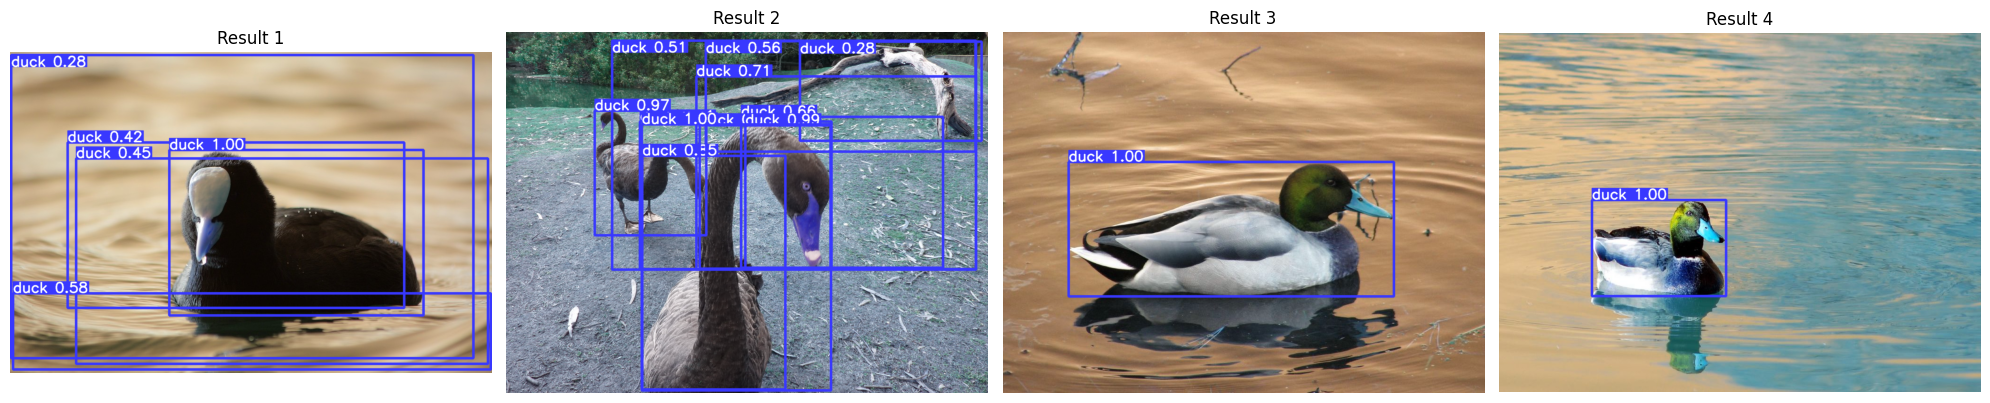

In [18]:
import matplotlib.pyplot as plt
train1_images = random.sample(image_paths, 4)
results = model.predict(train1_images)
# Create a 1x4 subplot grid
fig, axes = plt.subplots(1, 4, figsize=(20, 5))  # Adjust figsize as needed

# Plot each image in the subplot
for i, result in enumerate(results):
    # Convert PIL image to numpy array for plotting
    image_array = result.plot()
    
    # Plot the image on the corresponding subplot
    axes[i].imshow(image_array)
    axes[i].axis('off')  # Turn off axis labels
    
    # Set title for each subplot (optional)
    axes[i].set_title(f"Result {i+1}")
    
# Adjust layout and display the plot
plt.tight_layout()
plt.show()

- Does not perform well with reflections
- Does not work well when there are multiple detections

## 5. [1 point] Impact of augmentations.

In [2]:
!pip install albumentations==1.0.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 511.7 kB/s eta 0:00:000:00:01
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.3
    Uninstalling albumentations-1.4.3:
      Successfully uninstalled albumentations-1.4.3


In [4]:
model = YOLO("yolov8n.pt")
results = model.train(data="./datasets/archive/train1_config.yaml", epochs=20, project="with augmentation", exist_ok=True,pretrained=True,workers=8)

Ultralytics YOLOv8.1.45 🚀 Python-3.8.18 torch-1.13.1 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11012MiB)
WARNING ⚠️ Upgrade to torch>=2.0.0 for deterministic training.
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=./datasets/archive/train1_config.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=with augmentation, name=train, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frame

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sriharib128. Use `wandb login --relogin` to force relogin


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /home2/surya_ravindra/A3/datasets/archive/labels/train1... 100 i


train: New cache created: /home2/surya_ravindra/A3/datasets/archive/labels/train1.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /home2/surya_ravindra/A3/datasets/archive/labels/val... 50 images,

val: New cache created: /home2/surya_ravindra/A3/datasets/archive/labels/val.cache


Plotting labels to with augmentation/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to with augmentation/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       2.5G      1.167      3.327      1.211          7        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         50         52    0.00333      0.962      0.576      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20       2.4G       1.04      2.573      1.209          6        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         50         52       0.44      0.692      0.637      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20       2.4G       1.02      2.507      1.156         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         50         52     0.0034      0.981      0.586      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20       2.4G     0.9349      2.243      1.104          7        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         50         52    0.00333      0.962      0.637      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20       2.4G     0.9646      2.096      1.176          7        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         50         52          1      0.104      0.615      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20       2.4G     0.9865      2.158      1.145          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         50         52          1     0.0353      0.585      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20       2.4G     0.9642      2.151      1.123         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         50         52      0.704     0.0769      0.398      0.228

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20       2.4G     0.9954      1.896      1.187         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         50         52      0.705      0.367      0.459      0.278

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20       2.4G     0.9637      1.938      1.151          7        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         50         52      0.568       0.43      0.498      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20       2.4G     0.9845      1.837      1.119          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         50         52      0.588      0.308      0.418      0.221


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.51G     0.9145      2.481      1.101          4        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         50         52      0.674      0.159      0.362      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20       2.4G      1.012      2.557      1.177          5        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         50         52      0.762       0.37       0.49      0.268

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20       2.4G     0.9901       2.33       1.17          4        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         50         52      0.784      0.423      0.536        0.3

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20       2.4G     0.9669      2.359      1.252          4        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         50         52      0.655      0.519      0.544      0.325

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20       2.4G     0.9685      2.314      1.199          5        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         50         52      0.467      0.538      0.439      0.211

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20       2.4G     0.9075      2.323      1.154          5        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         50         52       0.62      0.481      0.457      0.237

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20       2.4G     0.8854       2.18      1.151          6        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         50         52      0.646      0.462      0.483      0.272

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20       2.4G     0.9379      2.261      1.216          5        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         50         52       0.67      0.468      0.519       0.31

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20       2.4G      1.025      2.412      1.171          4        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         50         52      0.682      0.481      0.557      0.345

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20       2.4G     0.7922      2.014      1.043          4        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         50         52       0.62      0.635      0.603      0.371

20 epochs completed in 0.010 hours.
Optimizer stripped from with augmentation/train/weights/last.pt, 6.2MB
Optimizer stripped from with augmentation/train/weights/best.pt, 6.2MB

Validating with augmentation/train/weights/best.pt...
Ultralytics YOLOv8.1.45 🚀 Python-3.8.18 torch-1.13.1 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11012MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         50         52    0.00333      0.962      0.638      0.462
Speed: 1.2ms preprocess, 0.8ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to with augmentation/train


lr/pg0,▁▂▄▅▆▆▇▇█████▇▆▅▄▃▂▁
lr/pg1,▁▂▄▅▆▆▇▇█████▇▆▅▄▃▂▁
lr/pg2,▁▂▄▅▆▆▇▇█████▇▆▅▄▃▂▁
metrics/mAP50(B),▆█▇█▇▇▂▃▄▂▁▄▅▆▃▃▄▅▆█
metrics/mAP50-95(B),▇█▇██▅▂▃▄▂▁▃▄▅▂▂▃▄▅█
metrics/precision(B),▁▄▁▁██▆▆▅▅▆▆▆▆▄▅▆▆▆▁
metrics/recall(B),█▆██▂▁▁▃▄▃▂▃▄▅▅▄▄▄▄█
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▆▅▄▄▅▄▅▄▅▃▅▅▄▄▃▃▄▅▁


 **(i) Yes, the default YOLO v8 train run uses augmentations by default when the Albumentations library is installed.**

**Default Augmentations:**

- **albumentations:** A library that provides a wide array of image augmentation techniques. YOLO v8 integrates these augmentations with default settings:
    - Blur (p=0.01, blur_limit=(3, 7)): Randomly blurs images to simulate motion blur or defocus.
    - MedianBlur (p=0.01, blur_limit=(3, 7)): Applies median filtering to reduce noise and create smoother edges.
    - ToGray (p=0.01): Converts images to grayscale with a 1% probability.
    - CLAHE (p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8)): Contrast-limited adaptive histogram equalization to enhance local contrast.

**Additional Default Augmentations in YOLO v8:**

- **hsv_h, hsv_s, hsv_v:** Adjust hue, saturation, and value (brightness) for color variability and lighting simulation.
- **translate:** Randomly shifts images horizontally and vertically for partial object visibility.
- **scale:** Resizes images with a gain factor, mimicking objects at different distances.
- **fliplr:** Flips images horizontally to handle symmetrical objects and increase dataset diversity.
- **mosaic:** Combines four images into one, creating diverse scene compositions and object interactions.
- **auto_augment:** Applies a predefined augmentation policy (randaugment, autoaugment, augmix) for optimized classification.
- **erasing:** Randomly erases image regions to encourage focus on less salient features.
  
**To remove all augmentations:**

- We can either uninstall the albumentations library and then pass the additional arguments as 0
- We can comment out the albumentations part in ./data/augment.py file in source code and change the arguments to 0 in ./cfg/default.yaml in the source code.

In [6]:
remove_cache_files("./datasets/")

Removed: ./datasets/archive/labels/val.cache
Removed: ./datasets/archive/labels/train1.cache


In [7]:
!python -m pip show pip

Name: pip
Version: 23.3.1
Summary: The PyPA recommended tool for installing Python packages.
Home-page: https://pip.pypa.io/
Author: The pip developers
Author-email: distutils-sig@python.org
License: MIT
Location: /home2/surya_ravindra/miniconda3/envs/pytorch_conda/lib/python3.8/site-packages
Requires: 
Required-by: 


In [8]:
from ultralytics import YOLO
model = YOLO("yolov8n.pt")
results = model.train(data="./datasets/archive/train1_config.yaml", epochs=20, project="no augmentation", exist_ok=True,pretrained=True,workers=8,close_mosaic=0,hsv_h = 0, hsv_s = 0, hsv_v = 0, translate = 0, scale = 0 , fliplr= 0, mosaic= 0,auto_augment = None,erasing=0)

Ultralytics YOLOv8.1.45 🚀 Python-3.8.18 torch-1.13.1 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11012MiB)
WARNING ⚠️ Upgrade to torch>=2.0.0 for deterministic training.
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=./datasets/archive/train1_config.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=no augmentation, name=train, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=F

train: Scanning /home2/surya_ravindra/A3/datasets/archive/labels/train1... 100 i


train: New cache created: /home2/surya_ravindra/A3/datasets/archive/labels/train1.cache


val: Scanning /home2/surya_ravindra/A3/datasets/archive/labels/val... 50 images,

val: New cache created: /home2/surya_ravindra/A3/datasets/archive/labels/val.cache


Plotting labels to no augmentation/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to no augmentation/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.49G      1.234       3.88      1.352          4        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         50         52     0.0034      0.981      0.519      0.371



wandb: WARNING Step only supports monotonically increasing values, use define_metric to set a custom x axis. For details see: https://wandb.me/define-metric
wandb: WARNING (User provided step: 1 is less than current step: 2. Dropping entry: {'train/box_loss': 1.23381, 'train/cls_loss': 3.88002, 'train/dfl_loss': 1.35153, '_timestamp': 1712812615.3617501}).
wandb: WARNING (User provided step: 1 is less than current step: 2. Dropping entry: {'lr/pg0': 0.00012000000000000002, 'lr/pg1': 0.00012000000000000002, 'lr/pg2': 0.00012000000000000002, '_timestamp': 1712812615.3619862}).
wandb: WARNING (User provided step: 1 is less than current step: 2. Dropping entry: {'metrics/precision(B)': 0.0034, 'metrics/recall(B)': 0.98077, 'metrics/mAP50(B)': 0.51945, 'metrics/mAP50-95(B)': 0.37118, 'val/box_loss': 0.59566, 'val/cls_loss': 3.23663, 'val/dfl_loss': 1.04701, '_timestamp': 1712812616.1521819}).
wandb: WARNING (User provided step: 1 is less than current step: 2. Dropping entry: {'labels': {'_


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.39G      1.107      3.371      1.347          4        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         50         52     0.0034      0.981      0.562       0.38

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.39G     0.9059      2.685      1.124          4        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         50         52    0.00333      0.962      0.529      0.302

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.39G     0.6588      2.357      1.014          4        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         50         52    0.00333      0.962      0.602      0.397

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.39G     0.6713      2.001      1.022          4        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         50         52    0.00333      0.962      0.389      0.219

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20       2.4G     0.6102      1.939     0.9632          4        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         50         52     0.0584      0.712      0.402      0.236

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20       2.4G     0.5544      1.726     0.9278          5        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         50         52          1     0.0526       0.42       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.39G     0.5164      1.645     0.9146          4        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         50         52      0.874      0.133      0.349      0.197

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.39G     0.5021      1.545     0.9117          4        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         50         52      0.689      0.173       0.33      0.177

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20       2.4G     0.4635      1.487     0.8819          4        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         50         52      0.727      0.153      0.331      0.183

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.39G     0.4268      1.327     0.8765          4        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         50         52      0.693      0.346      0.418      0.233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/7 [00:00<?, ?it/s]wandb: WARNING (User provided step: 1 is less than current step: 2. Dropping entry: {'train_batch1': {'_type': 'image-file', 'sha256': 'b29fe31f20d2d2a6b1aa189105f23372db935b4beb0e76f84add1bf6aa4e5ed7', 'size': 621413, 'path': 'media/images/train_batch1_2_b29fe31f20d2d2a6b1aa.jpg', 'format': 'jpg', 'width': 1920, 'height': 1920}, '_timestamp': 1712812616.3481302}).
wandb: WARNING (User provided step: 1 is less than current step: 2. Dropping entry: {'train_batch2': {'_type': 'image-file', 'sha256': 'c0ca9cf895c2edf629985e13b06eb5a6a85c2517994249ca50952969abbd98d9', 'size': 561334, 'path': 'media/images/train_batch2_2_c0ca9cf895c2edf62998.jpg', 'format': 'jpg', 'width': 1920, 'height': 1920}, '_timestamp': 1712812616.4248261}).
wandb: WARNING (User provided step: 1 is less than current step: 2. Dropping entry: {'model/parameters': 3011043, 'model/GFLOPs': 0.0, 'model/speed_PyTorch(ms)': 0.784, '_timestamp': 1712812616.4259875}).
      12/20      2.39G

                   all         50         52      0.615       0.43      0.469       0.24

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.39G       0.39      1.197     0.8745          4        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         50         52      0.517      0.365      0.422       0.22

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.39G     0.3836      1.159     0.8438          4        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         50         52      0.501      0.463      0.451      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20       2.4G     0.3575      1.081     0.8405          5        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         50         52      0.533      0.549      0.514      0.276

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.39G      0.317      1.021     0.8256          4        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         50         52      0.585      0.543       0.54      0.308

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.39G     0.2707     0.9509     0.8209          4        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         50         52      0.578      0.552      0.547       0.31

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.39G     0.2652     0.8883     0.8031          4        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         50         52      0.582      0.558      0.553      0.327

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.39G     0.2631     0.8812     0.8076          4        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         50         52      0.562      0.577      0.558      0.338

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20       2.4G     0.1937     0.7981     0.7828          4        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         50         52      0.567      0.538      0.565      0.335

20 epochs completed in 0.009 hours.
Optimizer stripped from no augmentation/train/weights/last.pt, 6.2MB
Optimizer stripped from no augmentation/train/weights/best.pt, 6.2MB

Validating no augmentation/train/weights/best.pt...
Ultralytics YOLOv8.1.45 🚀 Python-3.8.18 torch-1.13.1 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11012MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         50         52    0.00333      0.962      0.601      0.397
Speed: 1.0ms preprocess, 0.8ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to no augmentation/train


lr/pg0,▁▂▄▅▆▆▇▇█████▇▆▅▄▃▂▁
lr/pg1,▁▂▄▅▆▆▇▇█████▇▆▅▄▃▂▁
lr/pg2,▁▂▄▅▆▆▇▇█████▇▆▅▄▃▂▁
metrics/mAP50(B),▆▇▆█▃▃▃▁▁▁▃▅▃▄▆▆▇▇▇█
metrics/mAP50-95(B),▇▇▅█▂▃▃▂▁▁▃▃▂▃▄▅▅▆▆█
metrics/precision(B),▁▁▁▁▁▁█▇▆▆▆▅▅▄▅▅▅▅▅▁
metrics/recall(B),█████▆▁▂▂▂▃▄▃▄▅▅▅▅▅█
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▇▆▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁


In [9]:
if not os.path.exists("./results_aug.yaml"):
    results = {}
    
    for weight in ["./no_aug.pt","./with_aug.pt"]:
        model = YOLO(weight)
        
        temp = "train1" if "100" in weight else "train"
        
        with open("./datasets/archive/config.yaml", 'r') as file:
            config = yaml.safe_load(file)
            config['val'] = f"images/{temp}"
        
        with open("./datasets/archive/val_config.yaml", 'w') as new_file:
            yaml.dump(config, new_file)
    
        remove_cache_files("./datasets/")
        val_map50 = model.val(data='./datasets/archive/config.yaml',workers=8).box.map50
        remove_cache_files("./datasets/")
        train_map50 = model.val(data='./datasets/archive/val_config.yaml',workers=8).box.map50 
        
        results[weight] = {
            'train_map50': str(train_map50),
            'val_map50': str(val_map50)
        }
    
    with open('results_aug.yaml', 'w') as results_file:
        yaml.dump(results, results_file, default_flow_style=False)
    
    print("Results saved to results_aug.yaml file.")
else:
    with open("./results_aug.yaml", 'r') as file:
        results = yaml.safe_load(file)

Removed: ./datasets/archive/labels/val.cache
Removed: ./datasets/archive/labels/train1.cache
Ultralytics YOLOv8.1.45 🚀 Python-3.8.18 torch-1.13.1 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11012MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients


val: Scanning /home2/surya_ravindra/A3/datasets/archive/labels/val... 50 images,

val: New cache created: /home2/surya_ravindra/A3/datasets/archive/labels/val.cache



                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         50         52    0.00333      0.962      0.596      0.394
Speed: 3.4ms preprocess, 3.7ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/val
Removed: ./datasets/archive/labels/val.cache
Ultralytics YOLOv8.1.45 🚀 Python-3.8.18 torch-1.13.1 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11012MiB)


val: Scanning /home2/surya_ravindra/A3/datasets/archive/labels/train... 400 imag


val: New cache created: /home2/surya_ravindra/A3/datasets/archive/labels/train.cache


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all        400        418    0.00317      0.911      0.326      0.225
Speed: 0.5ms preprocess, 1.5ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/val2
Removed: ./datasets/archive/labels/train.cache
Ultralytics YOLOv8.1.45 🚀 Python-3.8.18 torch-1.13.1 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11012MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients


val: Scanning /home2/surya_ravindra/A3/datasets/archive/labels/val... 50 images,

val: New cache created: /home2/surya_ravindra/A3/datasets/archive/labels/val.cache



                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         50         52    0.00333      0.962      0.629      0.458
Speed: 3.3ms preprocess, 3.0ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/val3
Removed: ./datasets/archive/labels/val.cache
Ultralytics YOLOv8.1.45 🚀 Python-3.8.18 torch-1.13.1 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11012MiB)


val: Scanning /home2/surya_ravindra/A3/datasets/archive/labels/train... 400 imag


val: New cache created: /home2/surya_ravindra/A3/datasets/archive/labels/train.cache


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all        400        418    0.00328      0.943      0.322      0.203
Speed: 0.6ms preprocess, 1.7ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/val4
Results saved to results.yaml file.


In [10]:
results

{'./no_aug.pt': {'train_map50': '0.3259574246165796',
  'val_map50': '0.5964069272794131'},
 './with_aug.pt': {'train_map50': '0.32247776323542965',
  'val_map50': '0.6288984176422745'}}

 **(ii) Impact of Augmentation Removal:**

- Yes, removing augmentations results in a **decrease** in performance on the validation set.
**Reasons for Performance Drop:**

- **Limited Dataset:** The model is trained on only 100 images, which is a relatively small dataset for object detection. Augmentations help mitigate this issue by increasing data diversity.
- **Overfitting:** Without augmentations, the model is more likely to overfit to the training data, reducing its ability to generalize to unseen images.

**(iii) Identifying the Most Important Augmentation:**

- **Mosaic Augmentation:** It is highly effective for object detection due to its ability to create diverse scene compositions and object interactions.
- **Geometric Augmentations:** Translation, scaling, and flipping also contribute significantly to robustness against variations in object position, size, and orientation.
- **HSV Augmentations:** These can be crucial for handling different lighting conditions and color variations.